In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install required libraries
!pip install catboost lightgbm

# Import necessary libraries
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Capstone/FedCycleData 3.csv')
print("Dataset columns:", df.columns.tolist())

# Data processing
df['ClientID'] = df['ClientID'].astype(str)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Define aggregation
grouped = df.groupby('ClientID')
num_cycles = grouped.size()

user_df = grouped.agg({
    'LengthofCycle': ['mean', 'std', lambda x: ((x < 24) | (x > 35)).mean()],
    'LengthofLutealPhase': ['mean', lambda x: (x < 10).mean()],
    'LengthofMenses': ['mean'],
    'UnusualBleeding': lambda x: (x == 'Y').mean(),
    'EstimatedDayofOvulation': ['mean', 'std'],
    'Age': 'first',
    'BMI': 'first',
    'Numberpreg': 'first',
    'MeanBleedingIntensity': ['mean'],
    'Abortions': 'first',
    'AgeM': 'first',
    'Breastfeeding': 'first'
})
# Flatten column names
user_df.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in user_df.columns]
print("Raw aggregated columns:", user_df.columns.tolist())

# Find the UnusualBleeding lambda column dynamically
unusual_bleeding_col = next(col for col in user_df.columns if col.startswith('UnusualBleeding_'))
user_df['num_cycles'] = num_cycles.values

# Rename columns to match model expectations
column_mapping = {
    'LengthofCycle_mean': 'AvgCycleLength',
    'LengthofCycle_std': 'StdCycleLength',
    'LengthofCycle_<lambda_0>': 'IrregularCyclesPercent',
    'LengthofLutealPhase_mean': 'AvgLutealPhase',
    'LengthofLutealPhase_<lambda_0>': 'ShortLutealPercent',
    'LengthofMenses_mean': 'AvgMensesLength',
    unusual_bleeding_col: 'UnusualBleedingPercent',  # Dynamic mapping
    'EstimatedDayofOvulation_mean': 'AvgOvulationDay',
    'EstimatedDayofOvulation_std': 'OvulationVariability',
    'Age_first': 'Age',
    'BMI_first': 'BMI',
    'Numberpreg_first': 'Numberpreg',
    'MeanBleedingIntensity_mean': 'AvgBleedingIntensity',
    'Abortions_first': 'Abortions',
    'AgeM_first': 'AgeM',
    'Breastfeeding_first': 'Breastfeeding'
}
user_df = user_df.rename(columns=column_mapping)
user_df['TotalCycles'] = num_cycles.values
print("Aggregated user_df columns after renaming:", user_df.columns.tolist())

# Derive absolute PRWI target
user_df['cycle_reg_score'] = np.clip(1 - (user_df['StdCycleLength'] / user_df['AvgCycleLength']), 0, 1)
ideal_cycle = 28
user_df['cycle_len_score'] = np.exp(-((user_df['AvgCycleLength'] - ideal_cycle)**2 / (2*3**2)))
ideal_luteal = 14
user_df['luteal_score'] = np.exp(-((user_df['AvgLutealPhase'] - ideal_luteal)**2 / (2*2**2)))
user_df['menses_score'] = np.where((user_df['AvgMensesLength'] >= 3) & (user_df['AvgMensesLength'] <= 7), 1, 0.5)
user_df['bleed_score'] = 1 - user_df['UnusualBleedingPercent']
ideal_ov = 14
user_df['ov_score'] = np.exp(-((user_df['AvgOvulationDay'] - ideal_ov)**2 / (2*3**2)))
components = ['cycle_reg_score', 'cycle_len_score', 'luteal_score', 'menses_score', 'bleed_score', 'ov_score']
user_df['PRWI_target'] = user_df[components].mean(axis=1) * 100

# Load Risk-Assessment model
with open('/content/drive/MyDrive/Capstone/menstrual_risk_user_model (1).pkl', 'rb') as f:
    risk_components = pickle.load(f)

# Check PKL structure
print("Risk-Assessment PKL keys:", risk_components.keys())
risk_feature_cols = risk_components['feature_names']
# Validate and impute missing features
missing_features = [col for col in risk_feature_cols if col not in user_df.columns]
if missing_features:
    print(f"Warning: Missing features in user_df for Risk-Assessment: {missing_features}")
    for col in missing_features:
        user_df[col] = 0  # Impute with 0
print("Risk-Assessment features:", risk_feature_cols)
risk_features = user_df[risk_feature_cols]
risk_features_scaled = risk_components['scaler'].transform(risk_features)
risk_probs = risk_components['model'].predict_proba(risk_features_scaled)
user_df['risk_class'] = np.argmax(risk_probs, axis=1)
user_df['risk_conf'] = np.clip(user_df['TotalCycles'] / 10, 0, 1)

# Load ClusterDev model
with open('/content/drive/MyDrive/Capstone/clusterdev_gmm_model.pkl', 'rb') as f:
    cluster_components = pickle.load(f)

# Check PKL structure
print("ClusterDev PKL keys:", cluster_components.keys())
cluster_feature_cols = cluster_components['feature_columns']
# Validate and impute missing features
missing_cluster_features = [col for col in cluster_feature_cols if col not in user_df.columns]
if missing_cluster_features:
    print(f"Warning: Missing features in user_df for ClusterDev: {missing_cluster_features}")
    for col in missing_cluster_features:
        user_df[col] = 0  # Impute with 0
print("ClusterDev features:", cluster_feature_cols)
cluster_features = user_df[cluster_feature_cols]
cluster_features_imp = cluster_components['imputer'].transform(cluster_features)
cluster_features_scaled = cluster_components['scaler'].transform(cluster_features_imp)
cluster_probs = cluster_components['gmm'].predict_proba(cluster_features_scaled)
user_df['cluster'] = cluster_components['gmm'].predict(cluster_features_scaled)
user_df['cluster_prob'] = cluster_probs.max(axis=1)

# Prepare features and target
features = ['risk_class', 'risk_conf', 'cluster', 'cluster_prob']
X = user_df[features]
y = user_df['PRWI_target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Dataset columns: ['ClientID', 'CycleNumber', 'Group', 'CycleWithPeakorNot', 'ReproductiveCategory', 'LengthofCycle', 'MeanCycleLength', 'EstimatedDayofOvulation', 'LengthofLutealPhase', 'FirstDayofHigh', 'TotalNumberofHighDays', 'TotalHighPostPeak', 'TotalNumberofPeakDays', 'TotalDaysofFertility', 'TotalFertilityFormula', 'LengthofMenses', 'MeanMensesLength', 'MensesScoreDayOne', 'MensesScoreDayTwo', 'MensesScoreDayThree', 'MensesScoreDayFour', 'MensesScoreDayFive', 'MensesScoreDaySix', 'MensesScoreDaySeven', 'MensesScoreDayEight', 'MensesScoreDayNine', 'MensesScoreDayTen', 'MensesScoreDay11', 'MensesScoreDay12', 'MensesScoreDay13', 'MensesScoreDay14', 'MensesScoreDay15', 'TotalMensesScore', 'MeanBleedingIntensity', 'NumberofDaysofIntercourse', 'IntercourseInFertileWindow', 'UnusualBleeding', 'PhasesBleeding', 'IntercourseDuringUnusBleed', 'Age', 'AgeM', 'Maristatus', 'MaristatusM', 'Yearsmarried', 'Wedding', 'Religion', 'ReligionM', 'Ethnicity', 'EthnicityM', 'Schoolyears', 'Schoolyea

In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

# Train Model: CatBoost Regressor
cat_model = CatBoostRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, verbose=0)
cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_test)
cat_mse = mean_squared_error(y_test, cat_pred)
print(f'CatBoost Test MSE: {cat_mse:.2f}')

CatBoost Test MSE: 180.01


In [ ]:
# Train Model 2: LightGBM Regressor
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, verbose=-1)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)
lgb_mse = mean_squared_error(y_test, lgb_pred)
print(f'LightGBM Test MSE: {lgb_mse:.2f}')

LightGBM Test MSE: 181.08


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Train Model: XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, verbosity=0)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_pred)
print(f'XGBoost Test MSE: {xgb_mse:.2f}')

XGBoost Test MSE: 92.52


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Function to compute metrics
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R²': r2}

# Compute metrics for each model
metrics = {
    'CatBoost': compute_metrics(y_test, cat_pred),
    'LightGBM': compute_metrics(y_test, lgb_pred),
}

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics).T  # transpose for nicer view
metrics_df = metrics_df[['MSE', 'RMSE', 'MAE', 'R²']]  # consistent column order

# Round for readability
metrics_df = metrics_df.round(4)

print("Model Performance Metrics:")
display(metrics_df)

Model Performance Metrics:


,MSE,RMSE,MAE,R²
CatBoost,2.6454,1.6265,1.3110,0.9573
LightGBM,4.1332,2.0330,1.7682,0.9333


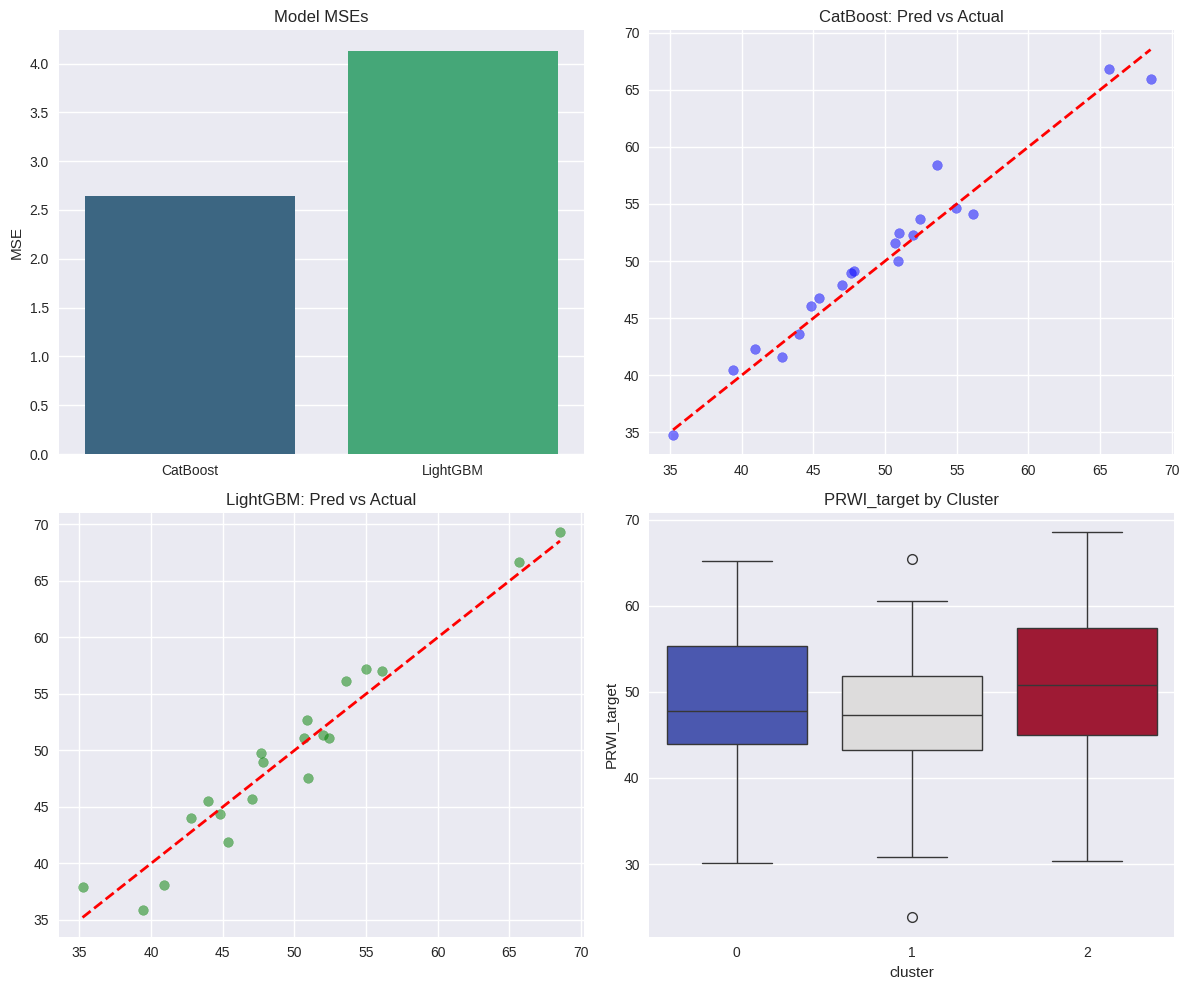

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')

# --- 1. Bar Plot of Model MSEs ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Adjusted to 2 rows × 2 cols

# Bar plot with hue to suppress warning
models = ['CatBoost', 'LightGBM']
mses = [cat_mse, lgb_mse]
sns.barplot(x=models, y=mses, hue=models, palette='viridis', ax=axes[0, 0], legend=False)
axes[0, 0].set_title('Model MSEs')
axes[0, 0].set_ylabel('MSE')

# --- 2. Scatter Plots Predicted vs Actual ---
axes[0, 1].scatter(y_test, cat_pred, alpha=0.5, color='blue')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_title('CatBoost: Pred vs Actual')

axes[1, 0].scatter(y_test, lgb_pred, alpha=0.5, color='green')
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 0].set_title('LightGBM: Pred vs Actual')

# --- 3. Box Plot by Cluster with hue to suppress warning ---
sns.boxplot(x='cluster', y='PRWI_target', hue='cluster', data=user_df, palette='coolwarm', ax=axes[1, 1], legend=False)
axes[1, 1].set_title('PRWI_target by Cluster')

plt.tight_layout()
plt.show()